In [1]:
import pandas as pd
import numpy as np
TWB2_hearing_loss_phenotype_data = pd.read_csv('TWB2_hearing_loss_phenotype_data')

In [2]:
TWB2_hearing_loss_phenotype_data

,TWB2_ID,AGE,I_32,hear_losing
0,TV2A_20190903G,37.0,0.0,0
1,TV29_20181601H,51.0,50.0,1
2,TV2A_20191203C,47.0,25.0,1
3,TV2K_20192407A,34.0,0.0,0
4,TV2K_20192403E,46.0,0.0,0
...,...,...,...,...
5692,TV2K_20190506D,60.0,0.0,0
5693,TV20_20180903G,47.0,25.0,1
5694,TV2K_20190802C,55.0,0.0,0
5695,TV2R_20201701F,59.0,0.0,0


In [3]:
import random
random.seed(10) 
normal_data = TWB2_hearing_loss_phenotype_data[TWB2_hearing_loss_phenotype_data['hear_losing']==0]
case_data = TWB2_hearing_loss_phenotype_data[TWB2_hearing_loss_phenotype_data['hear_losing']==1]
normal_data_sampled = normal_data.loc[random.sample(list(normal_data.index),len(case_data))]
len(normal_data),len(case_data),len(normal_data_sampled)

(3844, 1853, 1853)

In [4]:
# set gpu
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
def table():
    table = {}
    for first in list('ATCG'):
        for second in list('ATCG'):
            table[first+" "+second] = first+second
    table['0 0'] = '00'
    return table

In [6]:
ped = pd.read_table('hear_losing_top_5000.ped', sep= '\t', low_memory=False, header= None)
ped.iloc[:,6:] = ped.iloc[:,6:].replace(table())

In [7]:
ped

,0,1,2,3,4,5,6,7,8,9,...,4996,4997,4998,4999,5000,5001,5002,5003,5004,5005
0,TV2A_20190103D,TV2A_20190103D,0,0,2,1,CC,CC,TC,TT,...,GG,AA,CC,GG,GG,CC,AG,CC,AA,GG
1,TV2A_20190103F,TV2A_20190103F,0,0,2,1,CC,CC,TT,TT,...,GG,AA,CC,GG,GG,CC,GG,CC,AG,GG
2,TV2A_20190103G,TV2A_20190103G,0,0,2,1,CC,CC,TC,TT,...,GG,AA,CC,GG,GG,TC,GG,CC,AG,GG
3,TV2A_20190103H,TV2A_20190103H,0,0,2,1,CC,CC,CC,TT,...,GG,AA,CC,AA,GG,CC,GG,CC,AG,GG
4,TV2A_20190104B,TV2A_20190104B,0,0,2,1,CC,CC,TT,TT,...,AG,AA,CC,AG,GG,CC,AG,CC,GG,AG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5692,TV29_20183812E,TV29_20183812E,0,0,1,1,CC,CC,CC,TT,...,GG,GA,CC,GG,GG,CC,AG,CC,GG,GG
5693,TV29_20183901E,TV29_20183901E,0,0,2,1,CC,CC,TC,TT,...,GG,AA,CC,GG,GG,CC,AG,CC,GG,GG
5694,TV29_20183904H,TV29_20183904H,0,0,2,1,TC,CC,TC,TT,...,GG,AA,CC,GG,GG,CC,AG,CC,AG,GG
5695,TV29_20183908A,TV29_20183908A,0,0,1,1,CC,CC,CC,TT,...,GG,AA,CC,GG,GG,CC,GG,CC,AG,GG


In [8]:
# generate integer encoding table(dict)
def integer_encode_table():
    snp_uni = ['00', 'AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC','GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    integer = list(range(len(snp_uni)))
    snp_uni
    table = {}
    for index,key in enumerate(snp_uni):
        table[key] = integer[index]
    return table

# generate SNP encoding table(dict)
def SNP_encode_table():
    table=integer_encode_table()
    snp_table={}
    x=[]
    for key,value in table.items():
        if value == 0:
            x.append(value)
            snp_table[key] = value
            continue
        else:
            for other_key in list(snp_table.keys()):
                if set(key) == set(other_key): 
                    snp_table[key]=snp_table[other_key]
                    value = snp_table[other_key]
                continue
            x.append(value)
            while value-1 not in x:
                x[-1] = value-1
                value = value -1       
            snp_table[key]=value
    return snp_table

In [9]:
case_snp_data = ped.iloc[:,6:][ped[1].isin(case_data.iloc[:,0])]
normal_data_sampled_snp_data = ped.iloc[:,6:][ped[1].isin(normal_data_sampled.iloc[:,0])]

In [10]:
data = pd.concat([normal_data_sampled_snp_data,case_snp_data])
# SNP_encoding then convert data format to np.array
data_encoded = np.array(data.replace(SNP_encode_table()))
# give labels 
labels = np.hstack((np.repeat(0, len(normal_data_sampled_snp_data)),np.repeat(1, len(case_snp_data))))

In [11]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data_encoded,labels,test_size=0.1,stratify=labels)

In [12]:
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras import optimizers

def dense_model(train_data):
    #get number of columns in training data
    n_cols = train_data.shape[1]
    # Input - Layer
    input_ = Input(shape=(n_cols))
    x = Embedding(11, 8)(input_)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Output- Layer
    output = Dense(1, activation = "sigmoid")(x)
    
    model = Model(input_, output)
    model.compile(optimizer = optimizers.Adam(learning_rate=5*1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [13]:
model = dense_model(train_data)

In [14]:
histroy = model.fit(train_data, train_labels, batch_size=32, epochs=30, validation_split=0.1)

Epoch 1/30
94/94 [==============================] - 5s 14ms/step - loss: 0.6909 - accuracy: 0.5328 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 2/30
94/94 [==============================] - 1s 10ms/step - loss: 0.6869 - accuracy: 0.5462 - val_loss: 0.6788 - val_accuracy: 0.7784
Epoch 3/30
94/94 [==============================] - 1s 10ms/step - loss: 0.6704 - accuracy: 0.6188 - val_loss: 0.6680 - val_accuracy: 0.5838
Epoch 4/30
94/94 [==============================] - 1s 10ms/step - loss: 0.6500 - accuracy: 0.6718 - val_loss: 0.6434 - val_accuracy: 0.6228
Epoch 5/30
94/94 [==============================] - 1s 10ms/step - loss: 0.6113 - accuracy: 0.7441 - val_loss: 0.6102 - val_accuracy: 0.8054
Epoch 6/30
94/94 [==============================] - 1s 10ms/step - loss: 0.5721 - accuracy: 0.7921 - val_loss: 0.5719 - val_accuracy: 0.8293
Epoch 7/30
94/94 [==============================] - 1s 10ms/step - loss: 0.5116 - accuracy: 0.8401 - val_loss: 0.5274 - val_accuracy: 0.8144
Epoch 8/30
94

In [15]:

from sklearn.metrics import accuracy_score,accuracy_score,f1_score,matthews_corrcoef,confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt
from matplotlib import gridspec
def show_histroy(csvlog_filepath):
    df = csvlog_filepath
    fig1 = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 2) 
    ax1 = fig1.add_subplot(gs[0,0])
    ax2 = fig1.add_subplot(gs[0,1])
    #
    ax1.set_title('Train Accuracy',fontsize = '14' )
    ax2.set_title('Train Loss', fontfamily = 'serif', fontsize = '18' )
    ax1.set_xlabel('Epoch', fontfamily = 'serif', fontsize = '13' )
    ax1.set_ylabel('Acc', fontfamily = 'serif', fontsize = '13' )
    ax2.set_xlabel('Epoch', fontfamily = 'serif', fontsize = '13' )
    ax2.set_ylabel('Loss', fontfamily = 'serif', fontsize = '13' )
    ax1.plot(df['accuracy'], label = 'train',linewidth=2)
    ax1.plot(df['val_accuracy'], label = 'validation',linewidth=2)
    ax2.plot(df['loss'], label = 'train',linewidth=2)
    ax2.plot(df['val_loss'], label = 'validation',linewidth=2)
    ax1.legend(['train', 'validation'], loc='upper left')
    ax2.legend(['train', 'validation'], loc='upper left')
   # fig1.savefig(plot_filepath)
    plt.show()

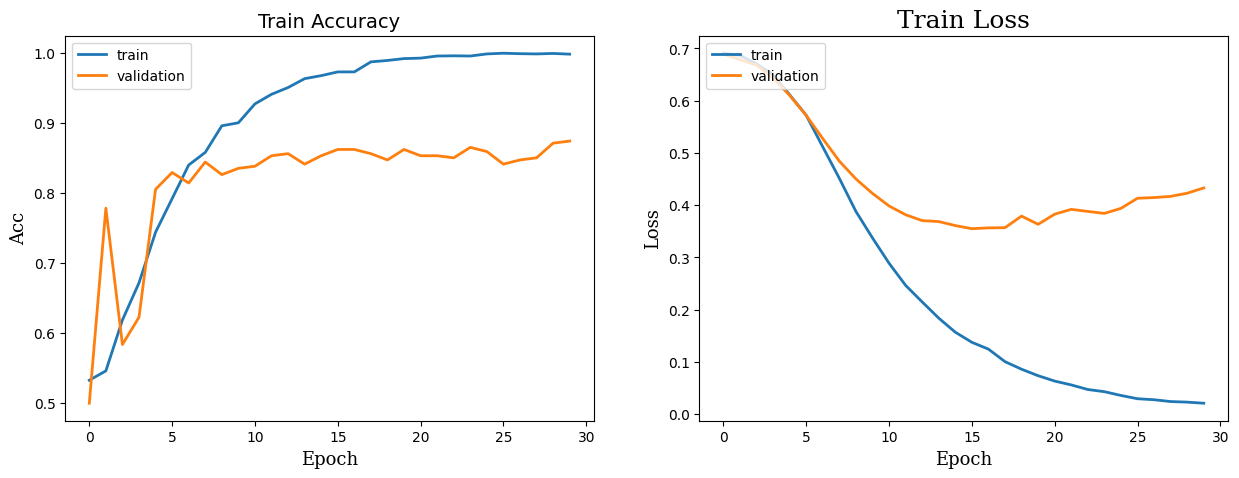

In [16]:
show_histroy(histroy.history)

In [17]:
def metric_array(test_data, test_labels, model):
    labels_score = model.predict(test_data)
    accuracy = accuracy_score(test_labels, labels_score.round())
    confusion = confusion_matrix(test_labels, labels_score.round())
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    precision = TP / float(TP + FP)
    sensitivity = TP / float(FN + TP)
    specificity = TN / float(TN + FP)
    f1 = f1_score(test_labels, labels_score.round())
    mcc = matthews_corrcoef(test_labels, labels_score.round()) 
    metric = {'accuracy':accuracy,
           'precision':precision,
           'sensitivity':sensitivity,
           'specificity':specificity,
           'f1':f1,
           'mcc':mcc}
    return metric

In [18]:
pd.DataFrame(metric_array(test_data, test_labels, model),index=['Dense'])

,accuracy,precision,sensitivity,specificity,f1,mcc
Dense,0.789757,0.803371,0.768817,0.810811,0.785714,0.5801
